In [136]:
import numpy as np
import pandas as pd
import yfinance as yf
import itertools
import matplotlib.pyplot as plt

from prophet import Prophet
from loguru import logger
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

In [154]:
# Download BCA stock data
ticker = 'BBCA.JK'
stock_data = yf.download(ticker, start='2005-01-01', end='2024-06-15')
stock_data.reset_index(inplace=True)

# Ensure the date column is in datetime format
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# Define the window size for volatility calculation
window_size = 21  # You can change this to any other number if needed

# Calculate returns and additional features
stock_data['Return'] = stock_data['Adj Close'].pct_change()
stock_data['Volatility'] = stock_data['Return'].rolling(window=window_size).std() * np.sqrt(252)
stock_data['SMA_50'] = stock_data['Adj Close'].rolling(window=50).mean()  # 50-day Simple Moving Average
stock_data['SMA_200'] = stock_data['Adj Close'].rolling(window=200).mean()  # 200-day Simple Moving Average
stock_data['Momentum'] = stock_data['Adj Close'] - stock_data['Adj Close'].shift(10)  # 10-day Momentum

# Prepare the data for Prophet with and without additional features
prophet_data = stock_data[['Date', 'Adj Close', 'Volatility', 'SMA_50', 'SMA_200', 'Momentum']].dropna()
prophet_data.rename(columns={'Date': 'ds', 'Adj Close': 'y'}, inplace=True)

prophet_data.head()

[*********************100%%**********************]  1 of 1 completed


,ds,y,Volatility,SMA_50,SMA_200,Momentum
199,2005-10-21,232.451309,0.261340,236.574483,228.715130,-6.990982
200,2005-10-24,232.451309,0.256334,236.295836,228.883746,-10.486450
201,2005-10-25,234.199051,0.252268,236.155519,229.044261,-5.243240
202,2005-10-26,232.451309,0.252326,236.083626,229.170774,-5.243225
203,2005-10-27,232.451309,0.239565,235.977274,229.297287,-3.495483


In [155]:
# Split data into training and test sets
train_data = prophet_data[prophet_data['ds'] < '2023-01-01']
test_data = prophet_data[prophet_data['ds'] >= '2023-01-01']

# Initialize and fit the model without additional features
model_no_features = Prophet()
model_no_features.fit(train_data[['ds', 'y']])

# Initialize and fit the model with additional features
model_with_features = Prophet()
model_with_features.add_regressor('Volatility')
model_with_features.add_regressor('SMA_50')
model_with_features.add_regressor('SMA_200')
model_with_features.add_regressor('Momentum')
model_with_features.fit(train_data)

# Create a future dataframe for the entire dataset and the forecast period
future_dates = pd.bdate_range(start=prophet_data['ds'].min(), end=test_data['ds'].max()).to_frame(index=False, name='ds')
future_no_features = pd.concat([pd.DataFrame({'ds': prophet_data['ds']}), future_dates]).drop_duplicates().reset_index(drop=True)
future_with_features = future_no_features.copy()

# Align the future dataframe with stock_data and fill in additional features for the model with features
future_with_features = future_with_features.merge(stock_data[['Date', 'Volatility', 'SMA_50', 'SMA_200', 'Momentum']], left_on='ds', right_on='Date', how='left')
future_with_features.drop(columns=['Date'], inplace=True)
future_with_features.fillna(method='ffill', inplace=True)

# # Make predictions
forecast_no_features = model_no_features.predict(future_no_features)
forecast_with_features = model_with_features.predict(future_with_features)

# # Filter predictions to match test period
forecast_no_features = forecast_no_features[forecast_no_features['ds'].isin(test_data['ds'])]
forecast_with_features = forecast_with_features[forecast_with_features['ds'].isin(test_data['ds'])]

# # Ensure test_data is aligned correctly for evaluation
test_data_aligned = test_data[test_data['ds'].isin(forecast_no_features['ds'])]

# # Evaluate performance
mae_no_features = mean_absolute_error(test_data_aligned['y'], forecast_no_features['yhat'])
mse_no_features = mean_squared_error(test_data_aligned['y'], forecast_no_features['yhat'])

mae_with_features = mean_absolute_error(test_data_aligned['y'], forecast_with_features['yhat'])
mse_with_features = mean_squared_error(test_data_aligned['y'], forecast_with_features['yhat'])

05:01:51 - cmdstanpy - INFO - Chain [1] start processing
05:01:52 - cmdstanpy - INFO - Chain [1] done processing
05:01:52 - cmdstanpy - INFO - Chain [1] start processing
05:01:53 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/dy/4b10p5f93zsgwjd934df1x_80000gn/T/ipykernel_30916/4208198463.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_with_features.fillna(method='ffill', inplace=True)


Model without Additional Features - MAE: 648.0609079129647, MSE: 526394.5745636034
Model with Additional Features - MAE: 168.23131166238304, MSE: 41416.00509862494


(19359.0, 19888.0)

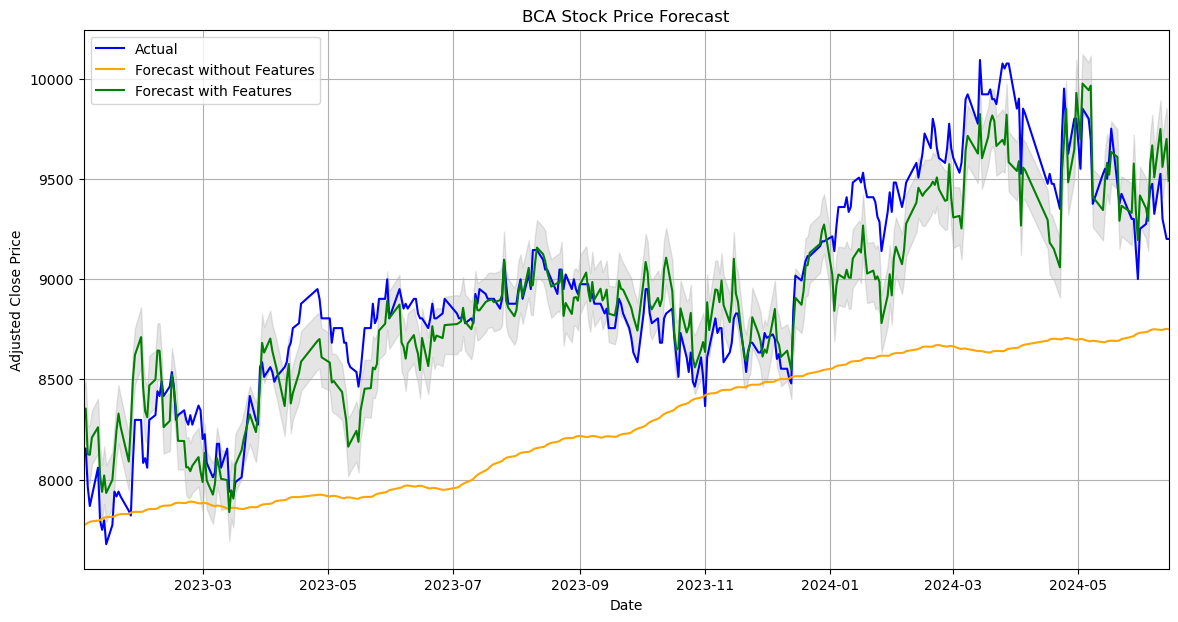

In [156]:
# Evals
print(f"Model without Additional Features - MAE: {mae_no_features}, MSE: {mse_no_features}")
print(f"Model with Additional Features - MAE: {mae_with_features}, MSE: {mse_with_features}")

# Plotting the forecast
plt.figure(figsize=(14, 7))
plt.plot(test_data_aligned['ds'], test_data_aligned['y'], label='Actual', color='blue')
plt.plot(forecast_no_features['ds'], forecast_no_features['yhat'], label='Forecast without Features', color='orange')
plt.plot(forecast_with_features['ds'], forecast_with_features['yhat'], label='Forecast with Features', color='green')
plt.fill_between(forecast_with_features['ds'], forecast_with_features['yhat_lower'], forecast_with_features['yhat_upper'], color='gray', alpha=0.2)
plt.title('BCA Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.grid(True)
plt.xlim(test_data_aligned['ds'].min(), test_data_aligned['ds'].max())

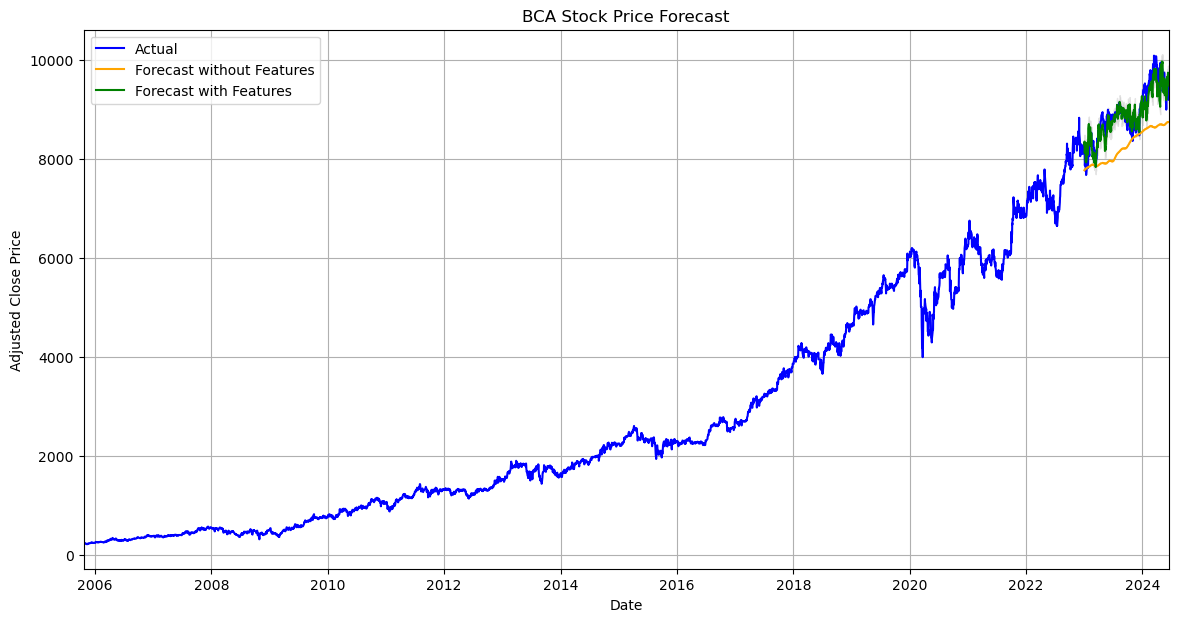

In [157]:
# Plotting the entire time series with forecast
plt.figure(figsize=(14, 7))
# Plot actual prices from the start
plt.plot(prophet_data['ds'], prophet_data['y'], label='Actual', color='blue')
# Plot forecast without additional features
plt.plot(forecast_no_features['ds'], forecast_no_features['yhat'], label='Forecast without Features', color='orange')
# Plot forecast with additional features
plt.plot(forecast_with_features['ds'], forecast_with_features['yhat'], label='Forecast with Features', color='green')
# Fill between forecast with features
plt.fill_between(forecast_with_features['ds'], forecast_with_features['yhat_lower'], forecast_with_features['yhat_upper'], color='gray', alpha=0.2)
plt.title('BCA Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.grid(True)
# Ensure x-axis covers the entire period
plt.xlim(prophet_data['ds'].min(), test_data['ds'].max())
plt.show()

/var/folders/dy/4b10p5f93zsgwjd934df1x_80000gn/T/ipykernel_30916/1777298013.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_with_features.fillna(method='ffill', inplace=True)


Model without Additional Features - MAE: 186.90703290024217, MSE: 90857.11544293218
Model with Additional Features - MAE: 79.30770239800059, MSE: 14549.905151726472


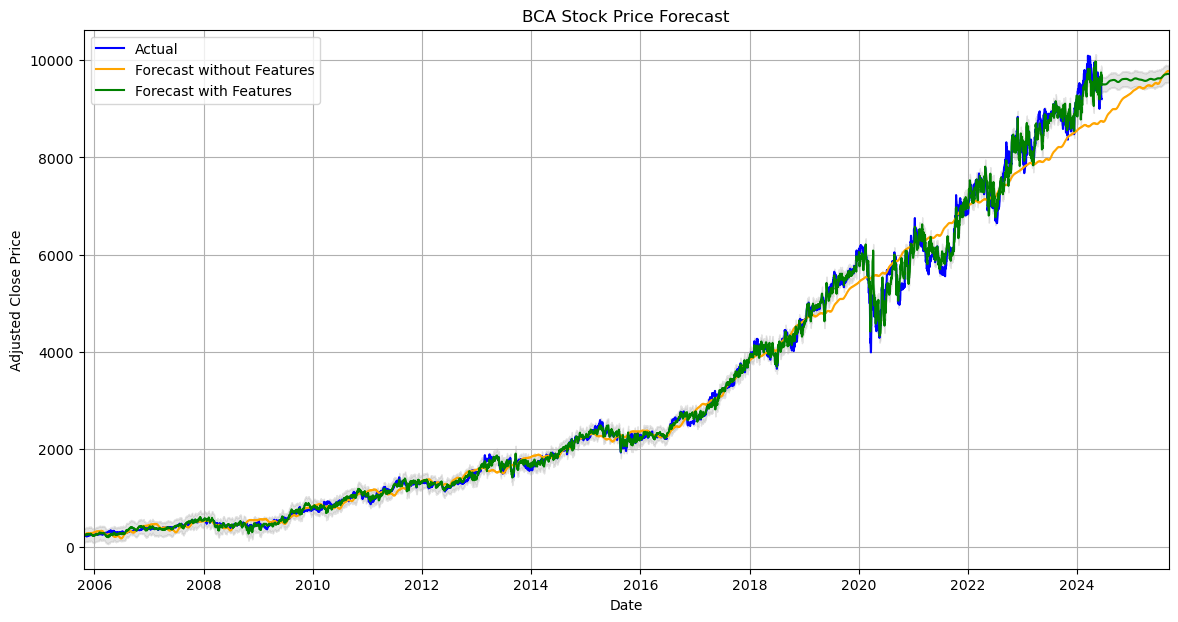

In [158]:
additional_days = 700  # Example: 365 days into the future

# Create a future dataframe for the entire dataset and the forecast period
future_no_features = model_no_features.make_future_dataframe(periods=additional_days, freq='B')
future_with_features = model_with_features.make_future_dataframe(periods=additional_days, freq='B')

# Align the future dataframe with stock_data and fill in additional features for the model with features
future_with_features = future_with_features.merge(stock_data[['Date', 'Volatility', 'SMA_50', 'SMA_200', 'Momentum']], left_on='ds', right_on='Date', how='left')
future_with_features.drop(columns=['Date'], inplace=True)
future_with_features.fillna(method='ffill', inplace=True)

# Make predictions for the entire dataset including future dates
forecast_no_features = model_no_features.predict(future_no_features)
forecast_with_features = model_with_features.predict(future_with_features)

# Evaluate performance on the test set
test_data_aligned = prophet_data[prophet_data['ds'].isin(forecast_no_features['ds'])]
mae_no_features = mean_absolute_error(test_data_aligned['y'], forecast_no_features.loc[forecast_no_features['ds'].isin(test_data_aligned['ds']), 'yhat'])
mse_no_features = mean_squared_error(test_data_aligned['y'], forecast_no_features.loc[forecast_no_features['ds'].isin(test_data_aligned['ds']), 'yhat'])

test_data_aligned_with_features = prophet_data[prophet_data['ds'].isin(forecast_with_features['ds'])]
mae_with_features = mean_absolute_error(test_data_aligned_with_features['y'], forecast_with_features.loc[forecast_with_features['ds'].isin(test_data_aligned_with_features['ds']), 'yhat'])
mse_with_features = mean_squared_error(test_data_aligned_with_features['y'], forecast_with_features.loc[forecast_with_features['ds'].isin(test_data_aligned_with_features['ds']), 'yhat'])

print(f"Model without Additional Features - MAE: {mae_no_features}, MSE: {mse_no_features}")
print(f"Model with Additional Features - MAE: {mae_with_features}, MSE: {mse_with_features}")

# Plotting the entire time series with forecast including future dates
plt.figure(figsize=(14, 7))
# Plot actual prices from the start
plt.plot(prophet_data['ds'], prophet_data['y'], label='Actual', color='blue')
# Plot forecast without additional features
plt.plot(forecast_no_features['ds'], forecast_no_features['yhat'], label='Forecast without Features', color='orange')
# Plot forecast with additional features
plt.plot(forecast_with_features['ds'], forecast_with_features['yhat'], label='Forecast with Features', color='green')
# Fill between forecast with features
plt.fill_between(forecast_with_features['ds'], forecast_with_features['yhat_lower'], forecast_with_features['yhat_upper'], color='gray', alpha=0.2)
plt.title('BCA Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.grid(True)
plt.xlim(prophet_data['ds'].min(), future_no_features['ds'].max())
plt.show()


In [142]:
test_data_aligned = test_data[test_data['ds'].isin(forecast_no_features['ds'])]
test_data

,ds,y,Volatility,SMA_50,SMA_200,Momentum
3225,2023-01-02,8154.729004,0.171491,8311.882529,7653.131670,-95.376465
3226,2023-01-03,8154.729004,0.165714,8309.666602,7656.125632,-23.843750
3227,2023-01-04,7963.975098,0.179653,8306.485781,7657.814927,-309.975098
3228,2023-01-05,7868.597656,0.161576,8298.547227,7658.793403,-309.975098
3229,2023-01-06,7916.286621,0.161655,8290.612412,7660.946045,-190.752930
...,...,...,...,...,...,...
3561,2024-06-10,9525.000000,0.254898,9630.598633,9184.084546,225.000000
3562,2024-06-11,9300.000000,0.264892,9618.171152,9186.077407,0.000000
3563,2024-06-12,9250.000000,0.239245,9604.743672,9187.212246,100.000000
3564,2024-06-13,9200.000000,0.231990,9589.827461,9188.461899,200.000000


In [159]:
# Function to calculate additional technical indicators
def add_technical_indicators(df):
    # Exponential Moving Average (EMA)
    df['EMA_12'] = df['Adj Close'].ewm(span=12, adjust=False).mean()
    df['EMA_26'] = df['Adj Close'].ewm(span=26, adjust=False).mean()

    # Relative Strength Index (RSI)
    delta = df['Adj Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # Bollinger Bands
    df['BB_Middle'] = df['Adj Close'].rolling(window=20).mean()
    df['BB_Upper'] = df['BB_Middle'] + 2 * df['Adj Close'].rolling(window=20).std()
    df['BB_Lower'] = df['BB_Middle'] - 2 * df['Adj Close'].rolling(window=20).std()

    # MACD
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # Stochastic Oscillator
    df['L14'] = df['Low'].rolling(window=14).min()
    df['H14'] = df['High'].rolling(window=14).max()
    df['%K'] = (df['Adj Close'] - df['L14']) * 100 / (df['H14'] - df['L14'])
    df['%D'] = df['%K'].rolling(window=3).mean()

    # On-Balance Volume (OBV)
    df['OBV'] = (np.sign(df['Adj Close'].diff()) * df['Volume']).fillna(0).cumsum()

    # Accumulation/Distribution Line
    df['AD'] = ((df['Adj Close'] - df['Low']) - (df['High'] - df['Adj Close'])) / (df['High'] - df['Low']) * df['Volume']
    df['ADL'] = df['AD'].cumsum()

    # Log Returns
    df['Log_Returns'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))

    # Skewness and Kurtosis
    df['Skewness'] = df['Log_Returns'].rolling(window=21).skew()
    df['Kurtosis'] = df['Log_Returns'].rolling(window=21).kurt()

    return df

# Download BCA stock data
ticker = 'BBCA.JK'
stock_data = yf.download(ticker, start='2010-01-01', end='2024-06-15')
stock_data.reset_index(inplace=True)

# Ensure the date column is in datetime format
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# Define the window size for volatility calculation
window_size = 21  # You can change this to any other number if needed

# Calculate additional features
stock_data['Volatility'] = stock_data['Adj Close'].pct_change().rolling(window=window_size).std() * np.sqrt(252)
stock_data['SMA_50'] = stock_data['Adj Close'].rolling(window=50).mean()  # 50-day Simple Moving Average
stock_data['SMA_200'] = stock_data['Adj Close'].rolling(window=200).mean()  # 200-day Simple Moving Average
stock_data['Momentum'] = stock_data['Adj Close'] - stock_data['Adj Close'].shift(10)  # 10-day Momentum

# Add more technical indicators
stock_data = add_technical_indicators(stock_data)

# Prepare the data for Prophet with additional features
prophet_data = stock_data[['Date', 'Adj Close', 'Volatility', 'SMA_50', 'SMA_200', 'Momentum', 'EMA_12', 'EMA_26', 'RSI', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'MACD', 'Signal', '%K', '%D', 'OBV', 'ADL', 'Log_Returns', 'Skewness', 'Kurtosis']].dropna()
prophet_data.rename(columns={'Date': 'ds', 'Adj Close': 'y'}, inplace=True)

prophet_data.tail()

# Split data into training and test sets
train_data = prophet_data[prophet_data['ds'] < '2023-01-01']
test_data = prophet_data[prophet_data['ds'] >= '2023-01-01']

# Initialize and fit the model without additional features
model_no_features = Prophet()
model_no_features.fit(train_data[['ds', 'y']])

# Initialize and fit the model with additional features
model_with_features = Prophet()
model_with_features.add_regressor('Volatility')
model_with_features.add_regressor('SMA_50')
model_with_features.add_regressor('SMA_200')
model_with_features.add_regressor('Momentum')
model_with_features.add_regressor('EMA_12')
model_with_features.add_regressor('EMA_26')
model_with_features.add_regressor('RSI')
model_with_features.add_regressor('BB_Middle')
model_with_features.add_regressor('BB_Upper')
model_with_features.add_regressor('BB_Lower')
model_with_features.add_regressor('MACD')
model_with_features.add_regressor('Signal')
model_with_features.add_regressor('%K')
model_with_features.add_regressor('%D')
model_with_features.add_regressor('OBV')
model_with_features.add_regressor('ADL')
model_with_features.add_regressor('Log_Returns')
model_with_features.add_regressor('Skewness')
model_with_features.add_regressor('Kurtosis')
model_with_features.fit(train_data)

# Specify the number of additional days to forecast
additional_days = 365  # Example: 365 days into the future

# Create a future dataframe for the entire dataset and the forecast period
future_no_features = model_no_features.make_future_dataframe(periods=additional_days, freq='B')
future_with_features = model_with_features.make_future_dataframe(periods=additional_days, freq='B')

# Align the future dataframe with stock_data and fill in additional features for the model with features
future_with_features = future_with_features.merge(stock_data[['Date', 'Volatility', 'SMA_50', 'SMA_200', 'Momentum', 'EMA_12', 'EMA_26', 'RSI', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'MACD', 'Signal', '%K', '%D', 'OBV', 'ADL', 'Log_Returns', 'Skewness', 'Kurtosis']], left_on='ds', right_on='Date', how='left')
future_with_features.drop(columns=['Date'], inplace=True)
future_with_features.fillna(method='ffill', inplace=True)

# Make predictions for the entire dataset including future dates
forecast_no_features = model_no_features.predict(future_no_features)
forecast_with_features = model_with_features.predict(future_with_features)

# Evaluate performance on the test set
test_data_aligned = test_data[test_data['ds'].isin(forecast_no_features['ds'])]
mae_no_features = mean_absolute_error(test_data_aligned['y'], forecast_no_features.loc[forecast_no_features['ds'].isin(test_data_aligned['ds']), 'yhat'])
mse_no_features = mean_squared_error(test_data_aligned['y'], forecast_no_features.loc[forecast_no_features['ds'].isin(test_data_aligned['ds']), 'yhat'])

test_data_aligned_with_features = test_data[test_data['ds'].isin(forecast_with_features['ds'])]
mae_with_features = mean_absolute_error(test_data_aligned_with_features['y'], forecast_with_features.loc[forecast_with_features['ds'].isin(test_data_aligned_with_features['ds']), 'yhat'])
mse_with_features = mean_squared_error(test_data_aligned_with_features['y'], forecast_with_features.loc[forecast_with_features['ds'].isin(test_data_aligned_with_features['ds']), 'yhat'])

print(f"Model without Additional Features - MAE: {mae_no_features}, MSE: {mse_no_features}")
print(f"Model with Additional Features - MAE: {mae_with_features}, MSE: {mse_with_features}")


[*********************100%%**********************]  1 of 1 completed
05:02:19 - cmdstanpy - INFO - Chain [1] start processing
05:02:20 - cmdstanpy - INFO - Chain [1] done processing
05:02:20 - cmdstanpy - INFO - Chain [1] start processing
05:02:21 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/dy/4b10p5f93zsgwjd934df1x_80000gn/T/ipykernel_30916/1906049760.py:112: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_with_features.fillna(method='ffill', inplace=True)


Model without Additional Features - MAE: 257.67005338513394, MSE: 97246.83824537297
Model with Additional Features - MAE: 35.679739458408825, MSE: 2083.6471674985323


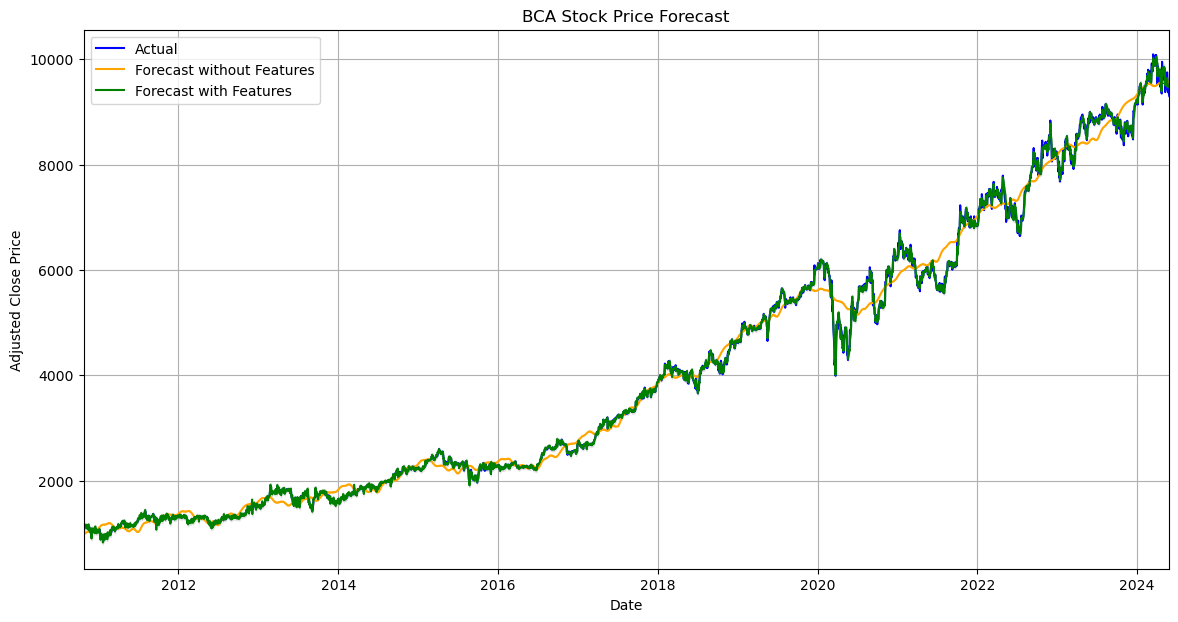

In [160]:
# Plotting the entire time series with forecast including future dates
plt.figure(figsize=(14, 7))
# Plot actual prices from the start
plt.plot(prophet_data['ds'], prophet_data['y'], label='Actual', color='blue')
# Plot forecast without additional features
plt.plot(forecast_no_features['ds'], forecast_no_features['yhat'], label='Forecast without Features', color='orange')
# Plot forecast with additional features
plt.plot(forecast_with_features['ds'], forecast_with_features['yhat'], label='Forecast with Features', color='green')
# Fill between forecast with features
plt.fill_between(forecast_with_features['ds'], forecast_with_features['yhat_lower'], forecast_with_features['yhat_upper'], color='gray', alpha=0.2)
plt.title('BCA Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.grid(True)
plt.xlim(prophet_data['ds'].min(), future_no_features['ds'].max())
plt.show()

[*********************100%%**********************]  1 of 1 completed
05:49:52 - cmdstanpy - INFO - Chain [1] start processing
05:49:53 - cmdstanpy - INFO - Chain [1] done processing
05:49:53 - cmdstanpy - INFO - Chain [1] start processing
05:49:54 - cmdstanpy - INFO - Chain [1] done processing
05:49:54 - cmdstanpy - INFO - Chain [1] start processing
05:49:56 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/dy/4b10p5f93zsgwjd934df1x_80000gn/T/ipykernel_30916/1804725730.py:118: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_with_features.fillna(method='ffill', inplace=True)
/var/folders/dy/4b10p5f93zsgwjd934df1x_80000gn/T/ipykernel_30916/1804725730.py:122: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  futures_with_volatility.fillna(method='ffill', inplace=True)


Model without Additional Features - MAE: 575.0783605778687, MSE: 430109.8076464405
Model with Volatility - MAE: 552.4403528514628, MSE: 403299.48850738216
Model with Additional Features - MAE: 41.06510892730954, MSE: 2769.010915237195


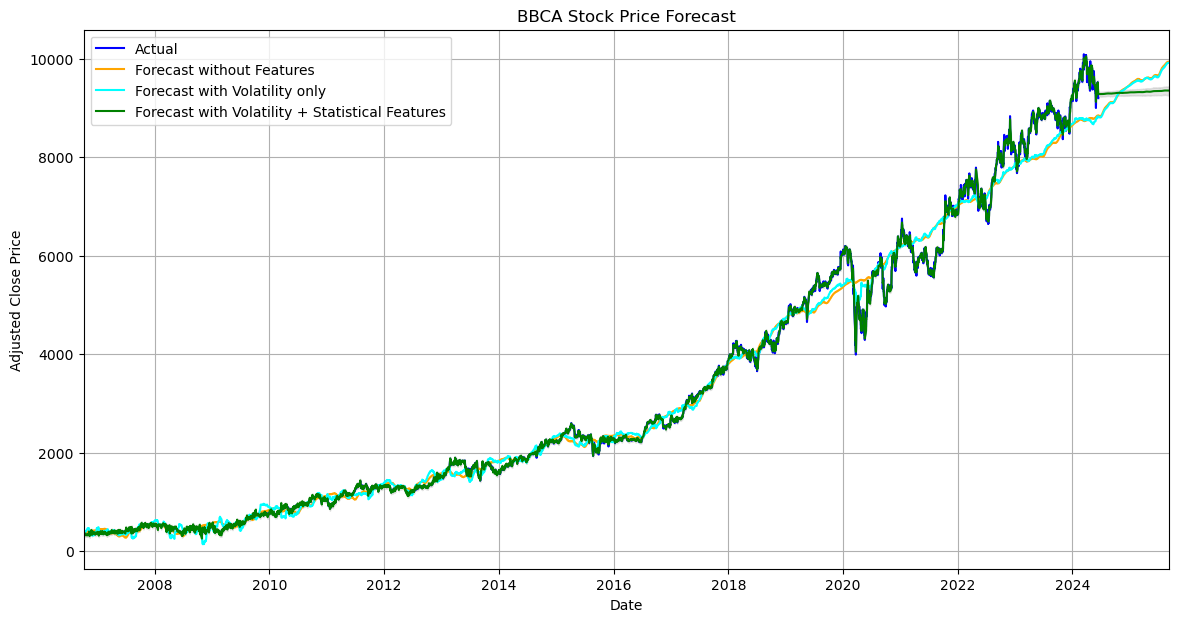

In [200]:
# Function to calculate additional technical indicators
def add_technical_indicators(df):
    # Exponential Moving Average (EMA)
    df['EMA_12'] = df['Adj Close'].ewm(span=12, adjust=False).mean()
    df['EMA_26'] = df['Adj Close'].ewm(span=26, adjust=False).mean()

    # Relative Strength Index (RSI)
    delta = df['Adj Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # Bollinger Bands
    df['BB_Middle'] = df['Adj Close'].rolling(window=20).mean()
    df['BB_Upper'] = df['BB_Middle'] + 2 * df['Adj Close'].rolling(window=20).std()
    df['BB_Lower'] = df['BB_Middle'] - 2 * df['Adj Close'].rolling(window=20).std()

    # MACD
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # Stochastic Oscillator
    df['L14'] = df['Low'].rolling(window=14).min()
    df['H14'] = df['High'].rolling(window=14).max()
    df['%K'] = (df['Adj Close'] - df['L14']) * 100 / (df['H14'] - df['L14'])
    df['%D'] = df['%K'].rolling(window=3).mean()

    # On-Balance Volume (OBV)
    df['OBV'] = (np.sign(df['Adj Close'].diff()) * df['Volume']).fillna(0).cumsum()

    # Accumulation/Distribution Line
    df['AD'] = ((df['Adj Close'] - df['Low']) - (df['High'] - df['Adj Close'])) / (df['High'] - df['Low']) * df['Volume']
    df['ADL'] = df['AD'].cumsum()

    # Log Returns
    df['Log_Returns'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))

    # Skewness and Kurtosis
    df['Skewness'] = df['Log_Returns'].rolling(window=21).skew()
    df['Kurtosis'] = df['Log_Returns'].rolling(window=21).kurt()

    return df

# Download BCA stock data
ticker = 'BBCA.JK'
stock_data = yf.download(ticker, start='2006-01-01', end='2024-06-15')
stock_data.reset_index(inplace=True)

# Ensure the date column is in datetime format
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# Define the window size for volatility calculation
window_size = 21  # You can change this to any other number if needed

# Calculate additional features
stock_data['Volatility'] = stock_data['Adj Close'].pct_change().rolling(window=window_size).std() * np.sqrt(252)
stock_data['SMA_50'] = stock_data['Adj Close'].rolling(window=50).mean()  # 50-day Simple Moving Average
stock_data['SMA_200'] = stock_data['Adj Close'].rolling(window=200).mean()  # 200-day Simple Moving Average
stock_data['Momentum'] = stock_data['Adj Close'] - stock_data['Adj Close'].shift(10)  # 10-day Momentum

# Add more technical indicators
stock_data = add_technical_indicators(stock_data)

# Prepare the data for Prophet with additional features
prophet_data = stock_data[['Date', 'Adj Close', 'Volatility', 'SMA_50', 'SMA_200', 'Momentum', 'EMA_12', 'EMA_26', 'RSI', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'MACD', 'Signal', '%K', '%D', 'OBV', 'ADL', 'Log_Returns', 'Skewness', 'Kurtosis']].dropna()
prophet_data.rename(columns={'Date': 'ds', 'Adj Close': 'y'}, inplace=True)

prophet_data.tail()

# Split data into training and test sets
train_data = prophet_data[prophet_data['ds'] < '2023-01-01']
test_data = prophet_data[prophet_data['ds'] >= '2023-01-01']

# Initialize and fit the model without additional features
model_no_features = Prophet()
model_no_features.fit(train_data[['ds', 'y']])

# Initialize model with volatility features only
model_with_volatility = Prophet()
model_with_volatility.add_regressor('Volatility')
model_with_volatility.fit(train_data)

# Initialize and fit the model with additional features
model_with_features = Prophet()
model_with_features.add_regressor('Volatility')
model_with_features.add_regressor('SMA_50')
model_with_features.add_regressor('SMA_200')
model_with_features.add_regressor('Momentum')
model_with_features.add_regressor('EMA_12')
model_with_features.add_regressor('EMA_26')
model_with_features.add_regressor('RSI')
model_with_features.add_regressor('BB_Middle')
model_with_features.add_regressor('BB_Upper')
model_with_features.add_regressor('BB_Lower')
model_with_features.add_regressor('MACD')
model_with_features.add_regressor('Signal')
model_with_features.add_regressor('%K')
model_with_features.add_regressor('%D')
model_with_features.add_regressor('OBV')
model_with_features.add_regressor('ADL')
model_with_features.add_regressor('Log_Returns')
model_with_features.add_regressor('Skewness')
model_with_features.add_regressor('Kurtosis')
model_with_features.fit(train_data)

# Specify the number of additional days to forecast
additional_days = 700  # Example: 700 days into the future

# Create a future dataframe for the entire dataset and the forecast period
future_no_features = model_no_features.make_future_dataframe(periods=additional_days, freq='B')
futures_with_volatility = model_with_volatility.make_future_dataframe(periods=additional_days, freq='B')
future_with_features = model_with_features.make_future_dataframe(periods=additional_days, freq='B')

# Align the future dataframe with stock_data and fill in additional features for the model with features
future_with_features = future_with_features.merge(stock_data[['Date', 'Volatility', 'SMA_50', 'SMA_200', 'Momentum', 'EMA_12', 'EMA_26', 'RSI', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'MACD', 'Signal', '%K', '%D', 'OBV', 'ADL', 'Log_Returns', 'Skewness', 'Kurtosis']], left_on='ds', right_on='Date', how='left')
future_with_features.drop(columns=['Date'], inplace=True)
future_with_features.fillna(method='ffill', inplace=True)

futures_with_volatility = futures_with_volatility.merge(stock_data[['Date', 'Volatility']], left_on='ds', right_on='Date', how='left')
futures_with_volatility.drop(columns=['Date'], inplace=True)
futures_with_volatility.fillna(method='ffill', inplace=True)

# Make predictions for the entire dataset including future dates
forecast_no_features = model_no_features.predict(future_no_features)
forecast_with_vol = model_with_volatility.predict(futures_with_volatility)
forecast_with_features = model_with_features.predict(future_with_features)

# Evaluate performance on the test set
test_data_aligned = test_data[test_data['ds'].isin(forecast_no_features['ds'])]
mae_no_features = mean_absolute_error(test_data_aligned['y'], forecast_no_features.loc[forecast_no_features['ds'].isin(test_data_aligned['ds']), 'yhat'])
mse_no_features = mean_squared_error(test_data_aligned['y'], forecast_no_features.loc[forecast_no_features['ds'].isin(test_data_aligned['ds']), 'yhat'])

test_data_aligned_with_features = test_data[test_data['ds'].isin(forecast_with_features['ds'])]
mae_with_features = mean_absolute_error(test_data_aligned_with_features['y'], forecast_with_features.loc[forecast_with_features['ds'].isin(test_data_aligned_with_features['ds']), 'yhat'])
mse_with_features = mean_squared_error(test_data_aligned_with_features['y'], forecast_with_features.loc[forecast_with_features['ds'].isin(test_data_aligned_with_features['ds']), 'yhat'])

test_data_aligned_with_vol = test_data[test_data['ds'].isin(forecast_with_vol['ds'])]
mae_with_vol = mean_absolute_error(test_data_aligned_with_vol['y'], forecast_with_vol.loc[forecast_with_vol['ds'].isin(test_data_aligned_with_vol['ds']), 'yhat'])
mse_with_vol = mean_squared_error(test_data_aligned_with_vol['y'], forecast_with_vol.loc[forecast_with_vol['ds'].isin(test_data_aligned_with_vol['ds']), 'yhat'])

print(f"Model without Additional Features - MAE: {mae_no_features}, MSE: {mse_no_features}")
print(f"Model with Volatility - MAE: {mae_with_vol}, MSE: {mse_with_vol}")
print(f"Model with Additional Features - MAE: {mae_with_features}, MSE: {mse_with_features}")

# Plotting the entire time series with forecast including future dates
plt.figure(figsize=(14, 7))
# Plot actual prices from the start
plt.plot(prophet_data['ds'], prophet_data['y'], label='Actual', color='blue')
# Plot forecast without additional features
plt.plot(forecast_no_features['ds'], forecast_no_features['yhat'], label='Forecast without Features', color='orange')
# Plot forecast with Volatility
plt.plot(forecast_with_vol['ds'], forecast_with_vol['yhat'], label='Forecast with Volatility only', color='cyan')
# Plot forecast with additional features
plt.plot(forecast_with_features['ds'], forecast_with_features['yhat'], label='Forecast with Volatility + Statistical Features', color='green')
# Fill between forecast with features
plt.fill_between(forecast_with_features['ds'], forecast_with_features['yhat_lower'], forecast_with_features['yhat_upper'], color='gray', alpha=0.2)
plt.title('BBCA Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.grid(True)
plt.xlim(prophet_data['ds'].min(), future_no_features['ds'].max())
plt.show()

In [3]:
# Function to calculate additional technical indicators
def add_technical_indicators(df):
    # Exponential Moving Average (EMA)
    df['EMA_12'] = df['Adj Close'].ewm(span=12, adjust=False).mean()
    df['EMA_26'] = df['Adj Close'].ewm(span=26, adjust=False).mean()

    # Relative Strength Index (RSI)
    delta = df['Adj Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # Bollinger Bands
    df['BB_Middle'] = df['Adj Close'].rolling(window=20).mean()
    df['BB_Upper'] = df['BB_Middle'] + 2 * df['Adj Close'].rolling(window=20).std()
    df['BB_Lower'] = df['BB_Middle'] - 2 * df['Adj Close'].rolling(window=20).std()

    # MACD
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # Stochastic Oscillator
    df['L14'] = df['Low'].rolling(window=14).min()
    df['H14'] = df['High'].rolling(window=14).max()
    df['%K'] = (df['Adj Close'] - df['L14']) * 100 / (df['H14'] - df['L14'])
    df['%D'] = df['%K'].rolling(window=3).mean()

    # On-Balance Volume (OBV)
    df['OBV'] = (np.sign(df['Adj Close'].diff()) * df['Volume']).fillna(0).cumsum()

    # Accumulation/Distribution Line
    df['AD'] = ((df['Adj Close'] - df['Low']) - (df['High'] - df['Adj Close'])) / (df['High'] - df['Low']) * df['Volume']
    df['ADL'] = df['AD'].cumsum()

    # Log Returns
    df['Log_Returns'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))

    # Skewness and Kurtosis
    df['Skewness'] = df['Log_Returns'].rolling(window=21).skew()
    df['Kurtosis'] = df['Log_Returns'].rolling(window=21).kurt()

    return df

def train_test_forecast(stock, experiment, forecast_days):
    # Download stock data
    ticker = f"{stock}.JK"        
    stock_data = yf.download(ticker, start='2006-01-01', end='2024-06-15')
    stock_data.reset_index(inplace=True)

    # Check if DataFrame is empty
    if stock_data.empty:
        raise ValueError(f"'{stock}' historical data might not be available in yahoo Finance. Please recheck.")
    # Check if DataFrame contains any NaN values
    if stock_data.isna().sum().sum() > 0:
        raise ValueError("DataFrame contains NaN values")

    # Ensure the date column is in datetime format
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])

    # Define the window size for volatility calculation
    window_size = 21  # You can change this to any other number if needed

    # Calculate additional features
    stock_data['Volatility'] = stock_data['Adj Close'].pct_change().rolling(window=window_size).std() * np.sqrt(252)
    stock_data['SMA_50'] = stock_data['Adj Close'].rolling(window=50).mean()  # 50-day Simple Moving Average
    stock_data['SMA_200'] = stock_data['Adj Close'].rolling(window=200).mean()  # 200-day Simple Moving Average
    stock_data['Momentum'] = stock_data['Adj Close'] - stock_data['Adj Close'].shift(10)  # 10-day Momentum

    # Add more technical indicators
    stock_data = add_technical_indicators(stock_data)

    # Prepare the data for Prophet with additional features
    prophet_data = stock_data[['Date', 'Adj Close', 'Volatility', 'SMA_50', 'SMA_200', 'Momentum', 'EMA_12', 'EMA_26', 'RSI', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'MACD', 'Signal', '%K', '%D', 'OBV', 'ADL', 'Log_Returns', 'Skewness', 'Kurtosis']].dropna()
    prophet_data.rename(columns={'Date': 'ds', 'Adj Close': 'y'}, inplace=True)

    prophet_data.tail()

    # Split data into training and test sets
    train_data = prophet_data[prophet_data['ds'] < '2023-01-01']
    test_data = prophet_data[prophet_data['ds'] >= '2023-01-01']

    # Initialize and fit the model without additional features
    model_no_features = Prophet()
    model_no_features.fit(train_data[['ds', 'y']])

    # Initialize model with volatility features only
    model_with_volatility = Prophet()
    model_with_volatility.add_regressor('Volatility')
    model_with_volatility.fit(train_data)

    # Initialize and fit the model with additional features
    model_with_features = Prophet()
    model_with_features.add_regressor('Volatility')
    model_with_features.add_regressor('SMA_50')
    model_with_features.add_regressor('SMA_200')
    model_with_features.add_regressor('Momentum')
    model_with_features.add_regressor('EMA_12')
    model_with_features.add_regressor('EMA_26')
    model_with_features.add_regressor('RSI')
    model_with_features.add_regressor('BB_Middle')
    model_with_features.add_regressor('BB_Upper')
    model_with_features.add_regressor('BB_Lower')
    model_with_features.add_regressor('MACD')
    model_with_features.add_regressor('Signal')
    model_with_features.add_regressor('%K')
    model_with_features.add_regressor('%D')
    model_with_features.add_regressor('OBV')
    model_with_features.add_regressor('ADL')
    model_with_features.add_regressor('Log_Returns')
    model_with_features.add_regressor('Skewness')
    model_with_features.add_regressor('Kurtosis')
    model_with_features.fit(train_data)

    # Specify the number of additional days to forecast
    additional_days = 700  # Example: 700 days into the future

    # Create a future dataframe for the entire dataset and the forecast period
    future_no_features = model_no_features.make_future_dataframe(periods=additional_days, freq='B')
    futures_with_volatility = model_with_volatility.make_future_dataframe(periods=additional_days, freq='B')
    future_with_features = model_with_features.make_future_dataframe(periods=additional_days, freq='B')

    # Align the future dataframe with stock_data and fill in additional features for the model with features
    future_with_features = future_with_features.merge(stock_data[['Date', 'Volatility', 'SMA_50', 'SMA_200', 'Momentum', 'EMA_12', 'EMA_26', 'RSI', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'MACD', 'Signal', '%K', '%D', 'OBV', 'ADL', 'Log_Returns', 'Skewness', 'Kurtosis']], left_on='ds', right_on='Date', how='left')
    future_with_features.drop(columns=['Date'], inplace=True)
    future_with_features.fillna(method='ffill', inplace=True)

    futures_with_volatility = futures_with_volatility.merge(stock_data[['Date', 'Volatility']], left_on='ds', right_on='Date', how='left')
    futures_with_volatility.drop(columns=['Date'], inplace=True)
    futures_with_volatility.fillna(method='ffill', inplace=True)

    # Make predictions for the entire dataset including future dates
    forecast_no_features = model_no_features.predict(future_no_features)
    forecast_with_vol = model_with_volatility.predict(futures_with_volatility)
    forecast_with_features = model_with_features.predict(future_with_features)
    
    # Evaluate performance on the test set
    test_data_aligned = test_data[test_data['ds'].isin(forecast_no_features['ds'])]
    mae_no_features = mean_absolute_error(test_data_aligned['y'], forecast_no_features.loc[forecast_no_features['ds'].isin(test_data_aligned['ds']), 'yhat'])
    mse_no_features = mean_squared_error(test_data_aligned['y'], forecast_no_features.loc[forecast_no_features['ds'].isin(test_data_aligned['ds']), 'yhat'])

    test_data_aligned_with_features = test_data[test_data['ds'].isin(forecast_with_features['ds'])]
    mae_with_features = mean_absolute_error(test_data_aligned_with_features['y'], forecast_with_features.loc[forecast_with_features['ds'].isin(test_data_aligned_with_features['ds']), 'yhat'])
    mse_with_features = mean_squared_error(test_data_aligned_with_features['y'], forecast_with_features.loc[forecast_with_features['ds'].isin(test_data_aligned_with_features['ds']), 'yhat'])

    test_data_aligned_with_vol = test_data[test_data['ds'].isin(forecast_with_vol['ds'])]
    mae_with_vol = mean_absolute_error(test_data_aligned_with_vol['y'], forecast_with_vol.loc[forecast_with_vol['ds'].isin(test_data_aligned_with_vol['ds']), 'yhat'])
    mse_with_vol = mean_squared_error(test_data_aligned_with_vol['y'], forecast_with_vol.loc[forecast_with_vol['ds'].isin(test_data_aligned_with_vol['ds']), 'yhat'])

    print(f"Model without Additional Features - MAE: {mae_no_features}, MSE: {mse_no_features}")
    print(f"Model with Volatility - MAE: {mae_with_vol}, MSE: {mse_with_vol}")
    print(f"Model with Additional Features - MAE: {mae_with_features}, MSE: {mse_with_features}")

    # Plotting the entire time series with forecast including future dates
    plt.figure(figsize=(14, 7))
    # Plot actual prices from the start
    plt.plot(prophet_data['ds'], prophet_data['y'], label='Actual', color='blue')
    # Plot forecast without additional features
    plt.plot(forecast_no_features['ds'], forecast_no_features['yhat'], label='Forecast without Features', color='orange')
    # Plot forecast with Volatility
    plt.plot(forecast_with_vol['ds'], forecast_with_vol['yhat'], label='Forecast with Volatility only', color='cyan')
    # Plot forecast with additional features
    plt.plot(forecast_with_features['ds'], forecast_with_features['yhat'], label='Forecast with Volatility + Statistical Features', color='green')
    # Fill between forecast with features
    plt.fill_between(forecast_with_features['ds'], forecast_with_features['yhat_lower'], forecast_with_features['yhat_upper'], color='gray', alpha=0.2)
    plt.title('BBCA Stock Price Forecast')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price')
    plt.legend()
    plt.grid(True)
    plt.xlim(prophet_data['ds'].min(), future_no_features['ds'].max())
    plt.show()



[*********************100%%**********************]  1 of 1 completed
12:10:57 - cmdstanpy - INFO - Chain [1] start processing
12:10:58 - cmdstanpy - INFO - Chain [1] done processing
12:10:58 - cmdstanpy - INFO - Chain [1] start processing
12:10:59 - cmdstanpy - INFO - Chain [1] done processing
12:10:59 - cmdstanpy - INFO - Chain [1] start processing
12:11:00 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/dy/4b10p5f93zsgwjd934df1x_80000gn/T/ipykernel_86977/1513417257.py:93: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_with_features.fillna(method='ffill', inplace=True)
/var/folders/dy/4b10p5f93zsgwjd934df1x_80000gn/T/ipykernel_86977/1513417257.py:97: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  futures_with_volatility.fillna(method='ffill', inplace=True)


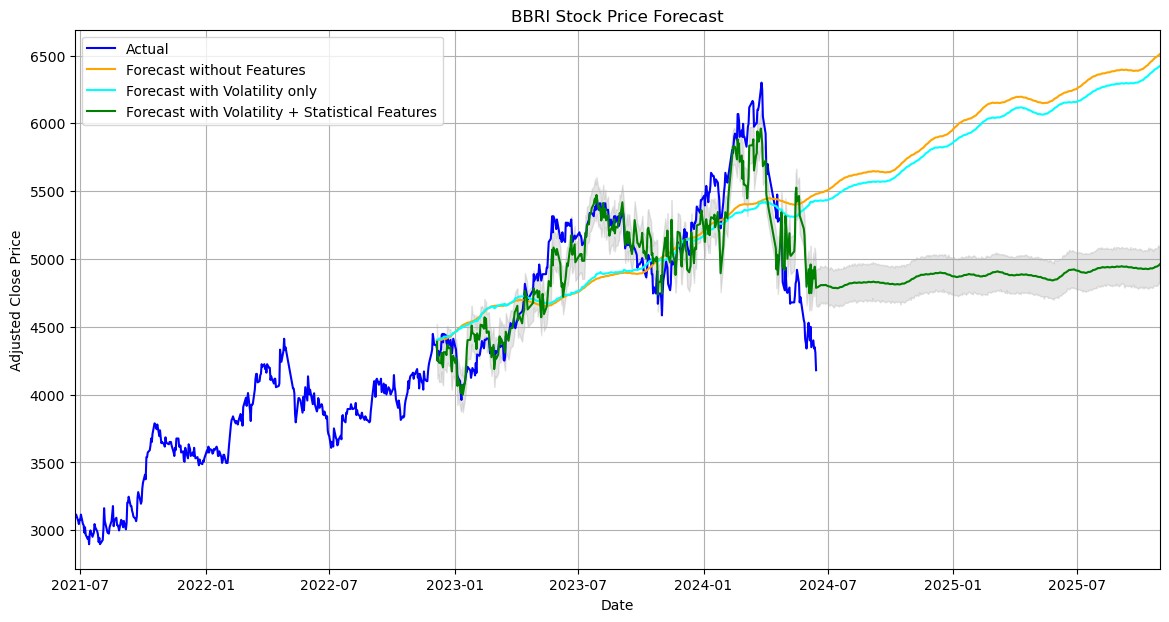

In [130]:
def train_test_forecast(stock, experiment, forecast_days):
    
    # Download stock data
    ticker = f"{stock}.JK"        
    stock_data = yf.download(ticker, start='2006-01-01', end='2024-06-15')
    stock_data.reset_index(inplace=True)

    # Check if DataFrame is empty
    if stock_data.empty:
        raise ValueError(f"'{stock}' historical data might not be available in yahoo Finance. Please recheck.")
    # Check if DataFrame contains any NaN values
    if stock_data.isna().sum().sum() > 0:
        raise ValueError("DataFrame contains NaN values")

    # Ensure the date column is in datetime format
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])

    # Define the window size for volatility calculation
    window_size = 21  # You can change this to any other number if needed

    # Calculate additional features
    stock_data['Volatility'] = stock_data['Adj Close'].pct_change().rolling(window=window_size).std() * np.sqrt(252)
    stock_data['SMA_50'] = stock_data['Adj Close'].rolling(window=50).mean()  # 50-day Simple Moving Average
    stock_data['SMA_200'] = stock_data['Adj Close'].rolling(window=200).mean()  # 200-day Simple Moving Average
    stock_data['Momentum'] = stock_data['Adj Close'] - stock_data['Adj Close'].shift(10)  # 10-day Momentum

    # Add more technical indicators
    stock_data = add_technical_indicators(stock_data)

    # Prepare the data for Prophet with additional features
    prophet_data = stock_data[['Date', 'Adj Close', 'Volatility', 'SMA_50', 'SMA_200', 'Momentum', 'EMA_12', 'EMA_26', 'RSI', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'MACD', 'Signal', '%K', '%D', 'OBV', 'ADL', 'Log_Returns', 'Skewness', 'Kurtosis']].dropna()
    prophet_data.rename(columns={'Date': 'ds', 'Adj Close': 'y'}, inplace=True)

    prophet_data.tail()

    if experiment:
        # Split data into training and test sets
        train_data, test_data = train_test_split(prophet_data, test_size=0.2, shuffle=False, stratify=None)

    else:
        train_data = prophet_data

    # Initialize and fit the model without additional features
    model_no_features = Prophet()
    model_no_features.fit(train_data[['ds', 'y']])

    # Initialize model with volatility features only
    model_with_volatility = Prophet()
    model_with_volatility.add_regressor('Volatility')
    model_with_volatility.fit(train_data)

    # Initialize and fit the model with additional features
    model_with_features = Prophet()
    model_with_features.add_regressor('Volatility')
    model_with_features.add_regressor('SMA_50')
    model_with_features.add_regressor('SMA_200')
    model_with_features.add_regressor('Momentum')
    # model_with_features.add_regressor('EMA_12')
    # model_with_features.add_regressor('EMA_26')
    # model_with_features.add_regressor('RSI')
    # model_with_features.add_regressor('BB_Middle')
    # model_with_features.add_regressor('BB_Upper')
    # model_with_features.add_regressor('BB_Lower')
    # model_with_features.add_regressor('MACD')
    # model_with_features.add_regressor('Signal')
    # model_with_features.add_regressor('%K')
    # model_with_features.add_regressor('%D')
    # model_with_features.add_regressor('OBV')
    # model_with_features.add_regressor('ADL')
    model_with_features.add_regressor('Log_Returns')
    model_with_features.add_regressor('Skewness')
    model_with_features.add_regressor('Kurtosis')
    model_with_features.fit(train_data)

    # Specify the number of additional days to forecast
    additional_days = forecast_days  # Example: 700 days into the future
    windows = -((additional_days * 2))
    if experiment:
        # Create a future dataframe for the entire dataset and the forecast period
        future_no_features = pd.DataFrame(test_data['ds'])
        futures_with_volatility = pd.DataFrame(test_data['ds'])
        future_with_features = pd.DataFrame(test_data['ds'])

    else:
        # Create a future dataframe for the entire dataset and the forecast period
        future_no_features = model_no_features.make_future_dataframe(periods=additional_days, freq='B').iloc[windows:]
        futures_with_volatility = model_with_volatility.make_future_dataframe(periods=additional_days, freq='B').iloc[windows:]
        future_with_features = model_with_features.make_future_dataframe(periods=additional_days, freq='B').iloc[windows:]

    # Align the future dataframe with stock_data and fill in additional features for the model with features
    future_with_features = future_with_features.merge(stock_data[['Date', 'Volatility', 'SMA_50', 'SMA_200', 'Momentum', 'EMA_12', 'EMA_26', 'RSI', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'MACD', 'Signal', '%K', '%D', 'OBV', 'ADL', 'Log_Returns', 'Skewness', 'Kurtosis']], left_on='ds', right_on='Date', how='left')
    future_with_features.drop(columns=['Date'], inplace=True)
    future_with_features.fillna(method='ffill', inplace=True)

    futures_with_volatility = futures_with_volatility.merge(stock_data[['Date', 'Volatility']], left_on='ds', right_on='Date', how='left')
    futures_with_volatility.drop(columns=['Date'], inplace=True)
    futures_with_volatility.fillna(method='ffill', inplace=True)

    # Make predictions for the entire dataset including future dates
    forecast_no_features = model_no_features.predict(future_no_features)
    forecast_with_vol = model_with_volatility.predict(futures_with_volatility)
    forecast_with_features = model_with_features.predict(future_with_features)
    
    if experiment:
        # Evaluate performance on the test set
        test_data_aligned = test_data[test_data['ds'].isin(forecast_no_features['ds'])]
        mae_no_features = mean_absolute_error(test_data_aligned['y'], forecast_no_features.loc[forecast_no_features['ds'].isin(test_data_aligned['ds']), 'yhat'])
        mse_no_features = mean_squared_error(test_data_aligned['y'], forecast_no_features.loc[forecast_no_features['ds'].isin(test_data_aligned['ds']), 'yhat'])

        test_data_aligned_with_features = test_data[test_data['ds'].isin(forecast_with_features['ds'])]
        mae_with_features = mean_absolute_error(test_data_aligned_with_features['y'], forecast_with_features.loc[forecast_with_features['ds'].isin(test_data_aligned_with_features['ds']), 'yhat'])
        mse_with_features = mean_squared_error(test_data_aligned_with_features['y'], forecast_with_features.loc[forecast_with_features['ds'].isin(test_data_aligned_with_features['ds']), 'yhat'])

        test_data_aligned_with_vol = test_data[test_data['ds'].isin(forecast_with_vol['ds'])]
        mae_with_vol = mean_absolute_error(test_data_aligned_with_vol['y'], forecast_with_vol.loc[forecast_with_vol['ds'].isin(test_data_aligned_with_vol['ds']), 'yhat'])
        mse_with_vol = mean_squared_error(test_data_aligned_with_vol['y'], forecast_with_vol.loc[forecast_with_vol['ds'].isin(test_data_aligned_with_vol['ds']), 'yhat'])

        print(f"Model without Additional Features - MAE: {mae_no_features}, MSE: {mse_no_features}")
        print(f"Model with Volatility - MAE: {mae_with_vol}, MSE: {mse_with_vol}")
        print(f"Model with Additional Features - MAE: {mae_with_features}, MSE: {mse_with_features}")

    # Plotting the entire time series with forecast including future dates
    plt.figure(figsize=(14, 7))

    if experiment:
        # Plot actual prices from the start
        plt.plot(prophet_data['ds'], prophet_data['y'], label='Actual', color='blue')

    else:
        # Plot actual prices from the start
        plt.plot(prophet_data['ds'][windows:], prophet_data['y'][windows:], label='Actual', color='blue')
        
    # Plot forecast without additional features
    plt.plot(forecast_no_features['ds'], forecast_no_features['yhat'], label='Forecast without Features', color='orange')
    # Plot forecast with Volatility
    plt.plot(forecast_with_vol['ds'], forecast_with_vol['yhat'], label='Forecast with Volatility only', color='cyan')
    # Plot forecast with additional features
    plt.plot(forecast_with_features['ds'], forecast_with_features['yhat'], label='Forecast with Volatility + Statistical Features', color='green')
    
    # Fill between forecast with features
    plt.fill_between(forecast_with_features['ds'], forecast_with_features['yhat_lower'], forecast_with_features['yhat_upper'], color='gray', alpha=0.2)
    plt.title(f'{stock} Stock Price Forecast')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price')
    plt.legend()
    plt.grid(True)
    if not experiment:
        plt.xlim(prophet_data['ds'][windows:].min(), future_no_features['ds'][windows:].max())
    else:
        plt.xlim(prophet_data['ds'][:].min(), future_no_features['ds'][:].max())
    plt.show()

    return forecast_no_features, forecast_with_vol, forecast_with_features

no, vol, features = train_test_forecast(stock="BBRI", experiment=False, forecast_days=360)

[*********************100%%**********************]  1 of 1 completed
13:37:36 - cmdstanpy - INFO - Chain [1] start processing
13:37:42 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/dy/4b10p5f93zsgwjd934df1x_80000gn/T/ipykernel_86977/3384608362.py:65: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future.fillna(method='ffill', inplace=True)
13:37:42 - cmdstanpy - INFO - Chain [1] start processing
13:37:49 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/dy/4b10p5f93zsgwjd934df1x_80000gn/T/ipykernel_86977/3384608362.py:65: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future.fillna(method='ffill', inplace=True)
13:37:49 - cmdstanpy - INFO - Chain [1] start processing
13:37:56 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/dy/4b10p5f93zsgwjd934df1x_80000gn/T/ipykernel_869

Best MAE: 127.60133098441908 with parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 150}


13:52:57 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/dy/4b10p5f93zsgwjd934df1x_80000gn/T/ipykernel_86977/3384608362.py:93: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_with_features.fillna(method='ffill', inplace=True)


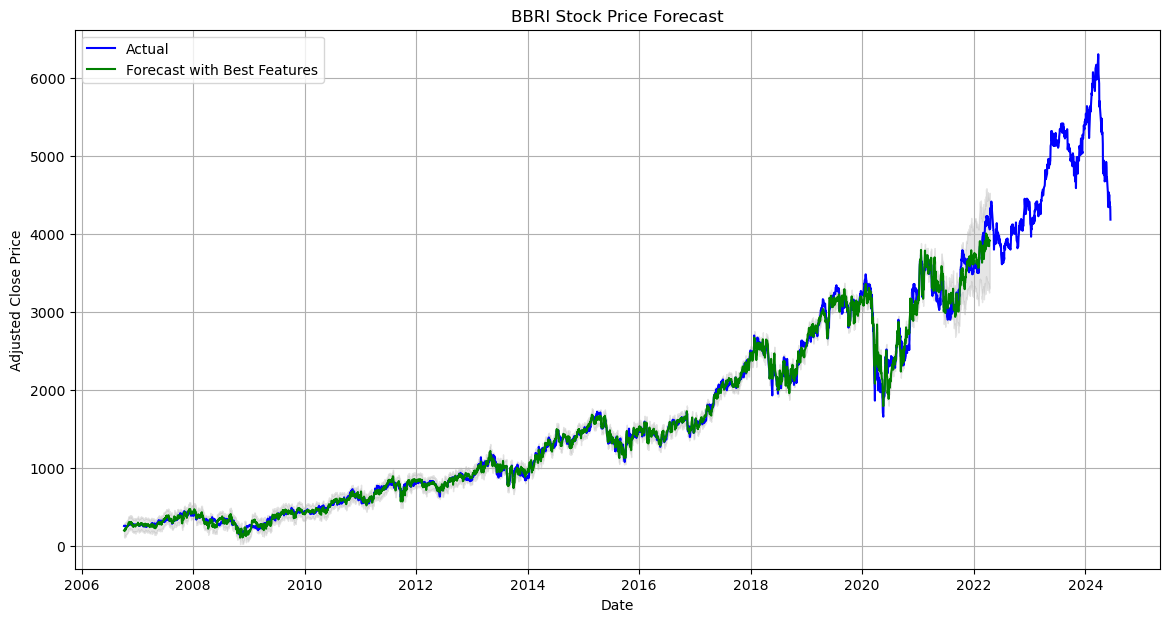

In [132]:
def train_test_forecast(stock, experiment, forecast_days):
    # Download stock data
    ticker = f"{stock}.JK"        
    stock_data = yf.download(ticker, start='2006-01-01', end='2024-06-15')
    stock_data.reset_index(inplace=True)

    # Check if DataFrame is empty
    if stock_data.empty:
        raise ValueError(f"'{stock}' historical data might not be available in yahoo Finance. Please recheck.")
    # Check if DataFrame contains any NaN values
    if stock_data.isna().sum().sum() > 0:
        raise ValueError("DataFrame contains NaN values")

    # Ensure the date column is in datetime format
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])

    # Define the window size for volatility calculation
    window_size = 21  # You can change this to any other number if needed

    # Calculate additional features
    stock_data['Volatility'] = stock_data['Adj Close'].pct_change().rolling(window=window_size).std() * np.sqrt(252)
    stock_data['SMA_50'] = stock_data['Adj Close'].rolling(window=50).mean()  # 50-day Simple Moving Average
    stock_data['SMA_200'] = stock_data['Adj Close'].rolling(window=200).mean()  # 200-day Simple Moving Average
    stock_data['Momentum'] = stock_data['Adj Close'] - stock_data['Adj Close'].shift(10)  # 10-day Momentum

    # Add more technical indicators
    stock_data = add_technical_indicators(stock_data)

    # Prepare the data for Prophet with additional features
    prophet_data = stock_data[['Date', 'Adj Close', 'Volatility', 'SMA_50', 'SMA_200', 'Momentum', 'EMA_12', 'EMA_26', 'RSI', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'MACD', 'Signal', '%K', '%D', 'OBV', 'ADL', 'Log_Returns', 'Skewness', 'Kurtosis']].dropna()
    prophet_data.rename(columns={'Date': 'ds', 'Adj Close': 'y'}, inplace=True)

    if experiment:
        # Split data into training and test sets
        train_data, test_data = train_test_split(prophet_data, test_size=0.2, shuffle=False, stratify=None)
    else:
        train_data = prophet_data

    # Hyperparameter tuning
    params_grid = {
        'seasonality_mode': ['multiplicative', 'additive'],
        'changepoint_prior_scale': [0.1, 0.2, 0.3, 0.4, 0.5],
        'holidays_prior_scale': [0.1, 0.2, 0.3, 0.4, 0.5],
        'n_changepoints': [100, 150, 200]
    }

    all_params = [dict(zip(params_grid.keys(), v)) for v in itertools.product(*params_grid.values())]
    best_params = None
    best_mae = float('inf')

    for params in all_params:
        model = Prophet(**params)
        model.add_regressor('Volatility')
        model.add_regressor('SMA_50')
        model.add_regressor('SMA_200')
        model.add_regressor('Momentum')
        model.add_regressor('Log_Returns')
        model.add_regressor('Skewness')
        model.add_regressor('Kurtosis')
        model.fit(train_data)
        
        future = model.make_future_dataframe(periods=forecast_days, freq='B')
        future = future.merge(stock_data[['Date', 'Volatility', 'SMA_50', 'SMA_200', 'Momentum', 'EMA_12', 'EMA_26', 'RSI', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'MACD', 'Signal', '%K', '%D', 'OBV', 'ADL', 'Log_Returns', 'Skewness', 'Kurtosis']], left_on='ds', right_on='Date', how='left')
        future.drop(columns=['Date'], inplace=True)
        future.fillna(method='ffill', inplace=True)
        
        forecast = model.predict(future)
        
        if experiment:
            test_data_aligned = test_data[test_data['ds'].isin(forecast['ds'])]
            mae = mean_absolute_error(test_data_aligned['y'], forecast.loc[forecast['ds'].isin(test_data_aligned['ds']), 'yhat'])
            if mae < best_mae:
                best_mae = mae
                best_params = params

    print(f"Best MAE: {best_mae} with parameters: {best_params}")

    # Initialize and fit the final model with best parameters
    model_with_features = Prophet(**best_params)
    model_with_features.add_regressor('Volatility')
    model_with_features.add_regressor('SMA_50')
    model_with_features.add_regressor('SMA_200')
    model_with_features.add_regressor('Momentum')
    model_with_features.add_regressor('Log_Returns')
    model_with_features.add_regressor('Skewness')
    model_with_features.add_regressor('Kurtosis')
    model_with_features.fit(train_data)

    # Create a future dataframe for the forecast period
    future_with_features = model_with_features.make_future_dataframe(periods=forecast_days, freq='B')
    future_with_features = future_with_features.merge(stock_data[['Date', 'Volatility', 'SMA_50', 'SMA_200', 'Momentum', 'EMA_12', 'EMA_26', 'RSI', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'MACD', 'Signal', '%K', '%D', 'OBV', 'ADL', 'Log_Returns', 'Skewness', 'Kurtosis']], left_on='ds', right_on='Date', how='left')
    future_with_features.drop(columns=['Date'], inplace=True)
    future_with_features.fillna(method='ffill', inplace=True)

    # Make predictions
    forecast_with_features = model_with_features.predict(future_with_features)

    # Plotting the entire time series with forecast including future dates
    plt.figure(figsize=(14, 7))

    if experiment:
        # Plot actual prices from the start
        plt.plot(prophet_data['ds'], prophet_data['y'], label='Actual', color='blue')
    else:
        # Plot actual prices from the start
        plt.plot(prophet_data['ds'], prophet_data['y'], label='Actual', color='blue')
        
    # Plot forecast with additional features
    plt.plot(forecast_with_features['ds'], forecast_with_features['yhat'], label='Forecast with Best Features', color='green')
    
    # Fill between forecast with features
    plt.fill_between(forecast_with_features['ds'], forecast_with_features['yhat_lower'], forecast_with_features['yhat_upper'], color='gray', alpha=0.2)
    plt.title(f'{stock} Stock Price Forecast')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    return forecast_with_features

forecast = train_test_forecast(stock="BBRI", experiment=True, forecast_days=360)

150

[*********************100%%**********************]  1 of 1 completed
2024-06-16 22:10:16.972 | INFO     | __main__:train_test_forecast:44 - Training raw model..
22:10:17 - cmdstanpy - INFO - Chain [1] start processing
22:10:18 - cmdstanpy - INFO - Chain [1] done processing
2024-06-16 22:10:18.551 | SUCCESS  | __main__:train_test_forecast:48 - Training Raw Model Done!..
2024-06-16 22:10:18.552 | INFO     | __main__:train_test_forecast:50 - Training Featured model..
22:10:18 - cmdstanpy - INFO - Chain [1] start processing
22:10:19 - cmdstanpy - INFO - Chain [1] done processing
2024-06-16 22:10:19.515 | SUCCESS  | __main__:train_test_forecast:61 - Training Featured Model Done!..
2024-06-16 22:10:19.515 | INFO     | __main__:train_test_forecast:76 - Training Optimized Model (epoch: 0 / 2))..
22:10:19 - cmdstanpy - INFO - Chain [1] start processing
22:10:25 - cmdstanpy - INFO - Chain [1] done processing
2024-06-16 22:10:25.959 | INFO     | __main__:train_test_forecast:76 - Training Optimize

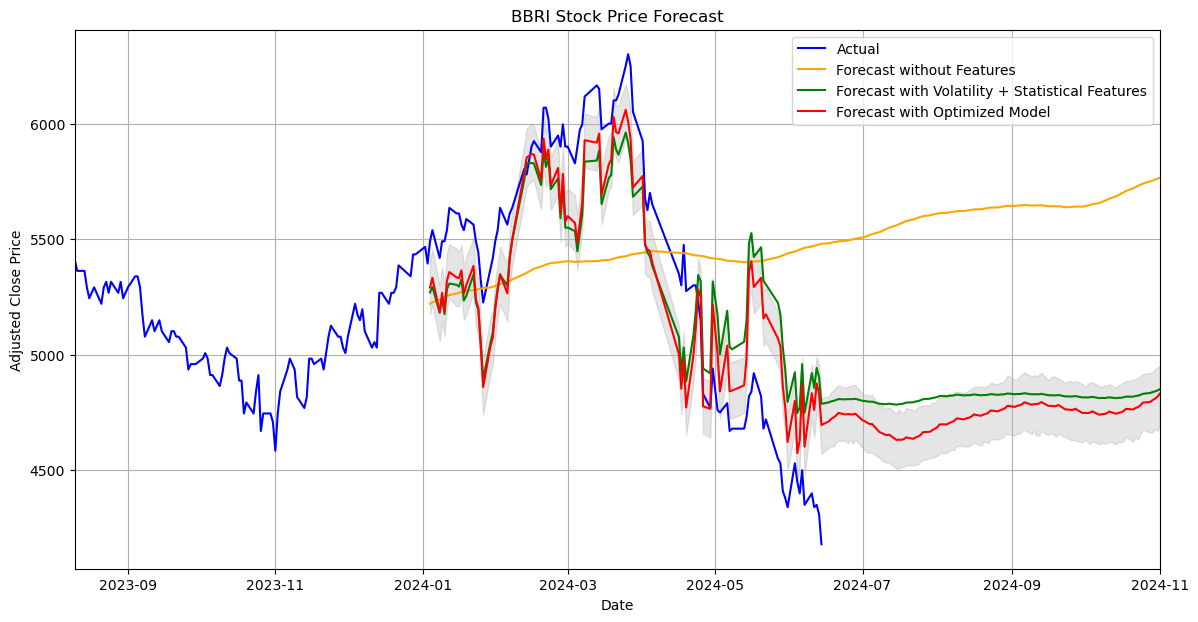

In [146]:

def train_test_forecast(stock, experiment, forecast_days):
    
    # Download stock data
    ticker = f"{stock}.JK"        
    stock_data = yf.download(ticker, start='2006-01-01', end='2024-06-15')
    stock_data.reset_index(inplace=True)

    # Check if DataFrame is empty
    if stock_data.empty:
        raise ValueError(f"'{stock}' historical data might not be available in yahoo Finance. Please recheck.")
    # Check if DataFrame contains any NaN values
    if stock_data.isna().sum().sum() > 0:
        raise ValueError("DataFrame contains NaN values")

    # Ensure the date column is in datetime format
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])

    # Define the window size for volatility calculation
    window_size = 21  # You can change this to any other number if needed

    # Calculate additional features
    stock_data['Volatility'] = stock_data['Adj Close'].pct_change().rolling(window=window_size).std() * np.sqrt(252)
    stock_data['SMA_50'] = stock_data['Adj Close'].rolling(window=50).mean()  # 50-day Simple Moving Average
    stock_data['SMA_200'] = stock_data['Adj Close'].rolling(window=200).mean()  # 200-day Simple Moving Average
    stock_data['Momentum'] = stock_data['Adj Close'] - stock_data['Adj Close'].shift(10)  # 10-day Momentum

    # Add more technical indicators
    stock_data = add_technical_indicators(stock_data)

    # Prepare the data for Prophet with additional features
    prophet_data = stock_data[['Date', 'Adj Close', 'Volatility', 'SMA_50', 'SMA_200', 'Momentum', 'EMA_12', 'EMA_26', 'RSI', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'MACD', 'Signal', '%K', '%D', 'OBV', 'ADL', 'Log_Returns', 'Skewness', 'Kurtosis']].dropna()
    prophet_data.rename(columns={'Date': 'ds', 'Adj Close': 'y'}, inplace=True)

    prophet_data.tail()

    if experiment:
        # Split data into training and test sets
        train_data, test_data = train_test_split(prophet_data, test_size=0.2, shuffle=False, stratify=None)

    else:
        _, test_data = train_test_split(prophet_data, test_size=0.2, shuffle=False, stratify=None)
        train_data = prophet_data

    logger.info(f"Training raw model..")
    # Initialize and fit the model without additional features
    model_no_features = Prophet()
    model_no_features.fit(train_data[['ds', 'y']])
    logger.success(f"Training Raw Model Done!..")
    
    logger.info(f"Training Featured model..")
    # Initialize and fit the model with additional features
    model_with_features = Prophet()
    model_with_features.add_regressor('Volatility')
    model_with_features.add_regressor('SMA_50')
    model_with_features.add_regressor('SMA_200')
    model_with_features.add_regressor('Momentum')
    model_with_features.add_regressor('Log_Returns')
    model_with_features.add_regressor('Skewness')
    model_with_features.add_regressor('Kurtosis')
    model_with_features.fit(train_data)
    logger.success(f"Training Featured Model Done!..")

    # Hyperparameter tuning
    params_grid = {
    'seasonality_mode': ['multiplicative', 'additive'],
    'changepoint_prior_scale': [0.1],
    'holidays_prior_scale': [0.1],
    'n_changepoints': [100]
    }

    all_params = [dict(zip(params_grid.keys(), v)) for v in itertools.product(*params_grid.values())]
    best_params = None
    best_mae = float('inf')

    for index, params in enumerate(all_params):
        logger.info(f"Training Optimized Model (epoch: {index} / {len(all_params)}))..")
        model = Prophet(**params)
        model.add_regressor('Volatility')
        model.add_regressor('SMA_50')
        model.add_regressor('SMA_200')
        model.add_regressor('Momentum')
        model.add_regressor('Log_Returns')
        model.add_regressor('Skewness')
        model.add_regressor('Kurtosis')
        model.fit(train_data)
        
        future = model.make_future_dataframe(periods=forecast_days, freq='B')
        future = future.merge(stock_data[['Date', 'Volatility', 'SMA_50', 'SMA_200', 'Momentum', 'EMA_12', 'EMA_26', 'RSI', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'MACD', 'Signal', '%K', '%D', 'OBV', 'ADL', 'Log_Returns', 'Skewness', 'Kurtosis']], left_on='ds', right_on='Date', how='left')
        future.drop(columns=['Date'], inplace=True)
        future.ffill(inplace=True)
        
        forecast = model.predict(future)
        
        test_data_aligned = test_data[test_data['ds'].isin(forecast['ds'])]
        mae = mean_absolute_error(test_data_aligned['y'], forecast.loc[forecast['ds'].isin(test_data_aligned['ds']), 'yhat'])
        if mae < best_mae:
            best_mae = mae
            best_params = params

    logger.success(f"Training Optimized Model Done!...")
    logger.info(f"Best MAE: {best_mae} with parameters: {best_params}")

    # Initialize and fit the final model with best parameters
    model_with_features_optimized = Prophet(**best_params)
    model_with_features_optimized.add_regressor('Volatility')
    model_with_features_optimized.add_regressor('SMA_50')
    model_with_features_optimized.add_regressor('SMA_200')
    model_with_features_optimized.add_regressor('Momentum')
    model_with_features_optimized.add_regressor('Log_Returns')
    model_with_features_optimized.add_regressor('Skewness')
    model_with_features_optimized.add_regressor('Kurtosis')
    model_with_features_optimized.fit(train_data)

    # Specify the number of additional days to forecast
    additional_days = forecast_days  # Example: 700 days into the future
    windows = -((additional_days * 2))

    if experiment:
        # Create a future dataframe for the entire dataset and the forecast period
        future_no_features = pd.DataFrame(test_data['ds'])
        future_with_features = pd.DataFrame(test_data['ds'])
        future_with_features_optimized = pd.DataFrame(test_data['ds'])

    else:
        # Create a future dataframe for the entire dataset and the forecast period
        future_no_features = model_no_features.make_future_dataframe(periods=additional_days, freq='B').iloc[windows:]
        future_with_features = model_with_features.make_future_dataframe(periods=additional_days, freq='B').iloc[windows:]
        future_with_features_optimized = model_with_features_optimized.make_future_dataframe(periods=additional_days, freq='B').iloc[windows:]


    # Align the future dataframe with stock_data and fill in additional features for the model with features
    future_with_features = future_with_features.merge(stock_data[['Date', 'Volatility', 'SMA_50', 'SMA_200', 'Momentum', 'EMA_12', 'EMA_26', 'RSI', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'MACD', 'Signal', '%K', '%D', 'OBV', 'ADL', 'Log_Returns', 'Skewness', 'Kurtosis']], left_on='ds', right_on='Date', how='left')
    future_with_features.drop(columns=['Date'], inplace=True)
    future_with_features.ffill(inplace=True)

    # Create an optimized future dataframe for the forecast period
    future_with_features_optimized = future_with_features_optimized.merge(stock_data[['Date', 'Volatility', 'SMA_50', 'SMA_200', 'Momentum', 'EMA_12', 'EMA_26', 'RSI', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'MACD', 'Signal', '%K', '%D', 'OBV', 'ADL', 'Log_Returns', 'Skewness', 'Kurtosis']], left_on='ds', right_on='Date', how='left')
    future_with_features_optimized.drop(columns=['Date'], inplace=True)
    future_with_features_optimized.ffill(inplace=True)
    
    # Make predictions for the entire dataset including future dates
    forecast_no_features = model_no_features.predict(future_no_features)
    forecast_with_features = model_with_features.predict(future_with_features)
    forecast_with_features_optimized = model_with_features_optimized.predict(future_with_features_optimized)
    
    if experiment:
        # Evaluate performance on the test set
        test_data_aligned = test_data[test_data['ds'].isin(forecast_no_features['ds'])]
        mae_no_features = mean_absolute_error(test_data_aligned['y'], forecast_no_features.loc[forecast_no_features['ds'].isin(test_data_aligned['ds']), 'yhat'])
        mse_no_features = mean_squared_error(test_data_aligned['y'], forecast_no_features.loc[forecast_no_features['ds'].isin(test_data_aligned['ds']), 'yhat'])

        test_data_aligned_with_features = test_data[test_data['ds'].isin(forecast_with_features['ds'])]
        mae_with_features = mean_absolute_error(test_data_aligned_with_features['y'], forecast_with_features.loc[forecast_with_features['ds'].isin(test_data_aligned_with_features['ds']), 'yhat'])
        mse_with_features = mean_squared_error(test_data_aligned_with_features['y'], forecast_with_features.loc[forecast_with_features['ds'].isin(test_data_aligned_with_features['ds']), 'yhat'])

        test_data_aligned_with_features_optimized = test_data[test_data['ds'].isin(forecast_with_features_optimized['ds'])]
        mae_with_features_optimized = mean_absolute_error(test_data_aligned_with_features_optimized['y'], forecast_with_features_optimized.loc[forecast_with_features_optimized['ds'].isin(test_data_aligned_with_features_optimized['ds']), 'yhat'])
        mse_with_features_optimized = mean_squared_error(test_data_aligned_with_features_optimized['y'], forecast_with_features_optimized.loc[forecast_with_features_optimized['ds'].isin(test_data_aligned_with_features_optimized['ds']), 'yhat'])

        print(f"Model without Additional Features - MAE: {mae_no_features}, MSE: {mse_no_features}")
        print(f"Model with Additional Features - MAE: {mae_with_features}, MSE: {mse_with_features}")
        print(f"Model with Optimized Additional Features - MAE: {mae_with_features_optimized}, MSE: {mse_with_features_optimized}")
        

    # Plotting the entire time series with forecast including future dates
    plt.figure(figsize=(14, 7))

    if experiment:
        # Plot actual prices from the start
        plt.plot(prophet_data['ds'], prophet_data['y'], label='Actual', color='blue')

    else:
        # Plot actual prices from the start
        plt.plot(prophet_data['ds'][windows:], prophet_data['y'][windows:], label='Actual', color='blue')
        
    # Plot forecast without additional features
    plt.plot(forecast_no_features['ds'], forecast_no_features['yhat'], label='Forecast without Features', color='orange')
    # Plot forecast with additional features
    plt.plot(forecast_with_features['ds'], forecast_with_features['yhat'], label='Forecast with Volatility + Statistical Features', color='green')
    # Plot forecast with Optimized features
    plt.plot(forecast_with_features_optimized['ds'], forecast_with_features_optimized['yhat'], label='Forecast with Optimized Model', color='red')
    
    # Fill between forecast with features
    plt.fill_between(forecast_with_features_optimized['ds'], forecast_with_features_optimized['yhat_lower'], forecast_with_features_optimized['yhat_upper'], color='gray', alpha=0.2)
    plt.title(f'{stock} Stock Price Forecast')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price')
    plt.legend()
    plt.grid(True)
    if not experiment:
        plt.xlim(prophet_data['ds'][windows:].min(), future_no_features['ds'][windows:].max())
    else:
        plt.xlim(prophet_data['ds'][:].min(), future_no_features['ds'][:].max())
    plt.show()

train_test_forecast(stock="BBRI", experiment=False, forecast_days=100)

In [142]:
future

,ds
3701,2020-11-30
3702,2020-12-01
3703,2020-12-02
3704,2020-12-03
3705,2020-12-04
...,...
4550,2024-06-10
4551,2024-06-11
4552,2024-06-12
4553,2024-06-13
